### A minimal example of feature visualization using bare PyTorch.

Using various forms of regularization to produce better visualizations will be left to another day.
See https://distill.pub/2017/feature-visualization/ for inspiration.

In [1]:
# Imports / Setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
from IPython import display
from torch import nn
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Functions for normalizing an image tensor.

def gauss_normalize(t):
    t = t.clone()
    for c in range(3):
        chan = t[c]
        t[c] += chan.mean()
        t[c] /= chan.std()
    return t

def stretch_normalize(t):
    t = t.clone()
    for c in range(3):
        chan = t[c]
        t[c] -= chan.min()
        t[c] /= chan.max() - chan.min()
    return t

In [3]:
# Get VGG16 pretrained on Imagenet.
model = torchvision.models.vgg16(pretrained=True)
print(model)

# Set up hooks to get output of intermediate layer we want to visualize.
# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6?u=ptrblck
act = None
def hook(model, input, output):
    global act
    act = output

# Max pool layers at 4, 9, 16, 23, 30
layer_ind = 23
hook = model.features[layer_ind].register_forward_hook(hook)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [10]:
# Make random input tensor.
# Run this cell each time you want to start the SGD loop
# from a random state.
inp = torch.randn((3, 224, 224))
inp = inp.unsqueeze(0)
inp.requires_grad = True

step:  0 activation:  662.8824462890625
step:  50 activation:  200092.65625
step:  100 activation:  718329.0625
step:  150 activation:  1313046.875
step:  200 activation:  1936506.875
step:  250 activation:  2578796.25
step:  300 activation:  3241921.0
step:  350 activation:  3915072.0
step:  400 activation:  4596369.5
step:  450 activation:  5293205.5


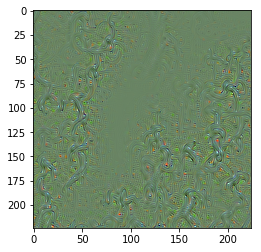

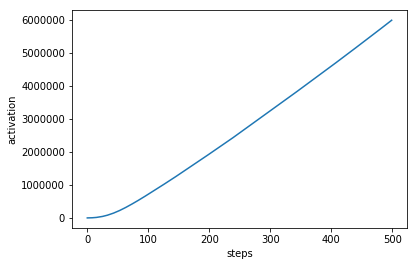

In [12]:
# Optimize input tensor to maximize sum of a channel in a layer.
# - It seems that use need to use more steps for higher layers.
# - Some random inits lead to zero activation and never improve.

# Good ones: 
# layer 16: 24, 26, 28
# layer 23: 13

channel_ind = 13
lr = 1.0
steps = 500
print_interval = 50
do_animate = False
act_sums = []

def plot_input(inp):
    norm_inp = stretch_normalize(inp.squeeze())
    norm_inp_np = norm_inp.detach().numpy().transpose([1, 2, 0])
    plt.imshow(norm_inp_np)

# SGD loop
for s in range(steps):
    # Compute sum of activations and backpropagate.
    out = model(inp)
    act_sum = act[0, channel_ind, :, :].sum()
    act_sum.backward()
    act_sums.append(act_sum.item())

    # Update input using gradient of input.
    with torch.no_grad():
        inp += inp.grad * lr
        
        inp.grad.zero_()
        model.zero_grad()
        
    if s % print_interval == 0:
        print('step: ', s, 'activation: ', act_sum.item())
        
        if do_animate:
            plot_input(inp)
            display.clear_output(wait=True)
            display.display(plt.gcf())

# Plots            
plot_input(inp)
plt.show()

plt.plot(np.arange(0, steps), np.array(act_sums))
plt.xlabel('steps')
plt.ylabel('activation')
plt.show()